# Continuous GFlowNets on a Simple 1D Line Environment

## Imports

In [1]:
from matplotlib import pyplot as plt
from torch.distributions import Normal
import math
import numpy as np
import torch
import random
from tqdm import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams['figure.dpi'] = 400

## Utils

In [2]:
def seed_all(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)


def render(reward, trajectory=None):
    """Renders the reward distribution over the 1D env."""
    x = np.linspace(
        min(reward.mus) - reward.n_sd * max(reward.sigmas),
        max(reward.mus) + reward.n_sd * max(reward.sigmas),
        1000,
    )

    d = torch.exp(reward.log_reward(torch.tensor(x)))
    dual_plot = not isinstance(trajectory, type(None))

    if dual_plot:
        fig, axs = plt.subplots(2, 1)
        axs = axs.ravel()
    else:
        fig, axs = plt.subplots(1, 1)
        axs = [axs]  # Hack to allow indexing.

    if dual_plot:
        ax_dual = axs[0].twinx()  # Second axes for final state counts.
        ax_dual.hist(
            trajectory[:, -1, 0].cpu().numpy(),  # Final X Position.
            bins=100,
            density=False,
            alpha=0.5,
            color="red",
        )
        ax_dual.set_ylabel("Samples", color="red")
        ax_dual.tick_params(axis="y", labelcolor="red")

        n, trajectory_length, _ = trajectory.shape
        for i in range(n):
            axs[1].plot(
                trajectory[i, :, 0].cpu().numpy(),
                np.arange(1, trajectory_length + 1),
                alpha=0.1,
                linewidth=0.05,
                color='black',
            )
            axs[1].set_ylabel('Step')

    axs[0].plot(x, d, color="black")

    # Adds the modes.
    for mu in reward.mus:
        axs[0].axvline(mu, color="grey", linestyle="--")

    # S0
    axs[0].plot([reward.init_value], [0], 'ro')
    axs[0].text(reward.init_value + 0.1, 0.01, "$S_0$", rotation=45)

    # Means
    for i, mu in enumerate(reward.mus):
        idx = abs(x - mu.numpy()) == min(abs(x - mu.numpy()))
        axs[0].plot([x[idx]], [d[idx]], 'bo')
        axs[0].text(x[idx] + 0.1, d[idx], "Mode {}".format(i + 1), rotation=0)

    axs[0].spines[['right', 'top']].set_visible(False)
    axs[0].set_ylabel("Reward Value")
    axs[0].set_title("Line Environment")
    axs[0].set_ylim(0, max(d) * 1.1)

    if dual_plot:
        axs[1].set_xlim(axs[0].get_xlim())
        axs[1].set_xlabel("X Position")
    else:
        axs[0].set_xlabel("X Position")

    fig.tight_layout()
    plt.show()


## Environment

In [3]:
class LineEnvironment():
    def __init__(self, mus, variances, n_sd, init_value):
        self.mus = torch.tensor(mus)
        self.sigmas = torch.tensor([math.sqrt(v) for v in variances])
        self.variances = torch.tensor(variances)
        self.mixture = [
            Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)
        ]

        self.n_sd = n_sd
        self.lb = min(self.mus) - self.n_sd * max(self.sigmas)  # Convienience only.
        self.ub = max(self.mus) + self.n_sd * max(self.sigmas)  # Convienience only.

        self.init_value = init_value  # Used for s0.
        assert self.lb < self.init_value < self.ub

    def log_reward(self, x):
        """Sum of the exponential of each log probability in the mixture."""
        return torch.logsumexp(torch.stack([m.log_prob(x) for m in self.mixture], 0), 0)

    @property
    def log_partition(self) -> float:
        """Log Partition is the log of the number of gaussians."""
        return torch.tensor(len(self.mus)).log()


## Functions

In [4]:
def setup_experiment(hid_dim=64, lr_model=1e-3, lr_logz=1e-1):
    forward_model = torch.nn.Sequential(torch.nn.Linear(2, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, 2)).to(device)

    backward_model = torch.nn.Sequential(torch.nn.Linear(2, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, 2)).to(device)

    logZ = torch.nn.Parameter(torch.tensor(0.0, device=device))

    optimizer = torch.optim.Adam(
        [
            {'params': forward_model.parameters(), 'lr': lr_model},
            {'params': backward_model.parameters(), 'lr': lr_model},
            {'params': [logZ], 'lr': lr_logz},
        ]
    )

    return (forward_model, backward_model, logZ, optimizer)

In [5]:
def step(x, action):
    """Takes a forward step in the environment."""
    new_x = torch.zeros_like(x)
    new_x[:, 0] = x[:, 0] + action  # Add action delta.
    new_x[:, 1] = x[:, 1] + 1  # Increment step counter.

    return new_x

def initalize_state(batch_size, device, env, randn=False):
    """Trajectory starts at state = (X_0, t=0)."""
    # t is used to prevent cycles in the graph
    x = torch.zeros((batch_size, 2), device=device)
    x[:, 0] = env.init_value

    return x

In [6]:
def inference(trajectory_length, forward_model, env, batch_size=10_000):
    """Sample some trajectories."""

    with torch.no_grad():
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        trajectory[:, 0, 0] = env.init_value

        x = initalize_state(batch_size, device, env)

        for t in range(trajectory_length):
            policy_dist = get_policy_dist(forward_model, x)
            action = policy_dist.sample()

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

    return trajectory

#### Without Exploration

In [7]:
def get_policy_dist(model, x):
    """
    A policy is a distribution we predict the parameters of using a neural network,
    which we then sample from.
    """
    pf_params = model(x)
    policy_mean = pf_params[:, 0]
    policy_std = torch.sigmoid(pf_params[:, 1]) * (max_policy_std - min_policy_std) + min_policy_std
    policy_dist = torch.distributions.Normal(policy_mean, policy_std)

    return policy_dist

In [8]:
def train(seed, batch_size, trajectory_length, env, device, n_iterations=10_000):
    """Continuous GFlowNet training loop, with the Trajectory Balance objective."""
    seed_all(seed)
    forward_model, backward_model, logZ, optimizer = setup_experiment()  # Default hyperparameters used.
    losses = []
    tbar = trange(n_iterations)

    for it in tbar:
        optimizer.zero_grad()

        x = initalize_state(batch_size, device, env)

        # Trajectory stores all of the states in the forward loop.
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        logPF = torch.zeros((batch_size,), device=device)
        logPB = torch.zeros((batch_size,), device=device)

        # Forward loop to generate full trajectory and compute logPF.
        for t in range(trajectory_length):
            policy_dist = get_policy_dist(forward_model, x)
            action = policy_dist.sample()
            logPF += policy_dist.log_prob(action)

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

        # Backward loop to compute logPB from existing trajectory under the backward policy.
        for t in range(trajectory_length, 2, -1):
            policy_dist = get_policy_dist(backward_model, trajectory[:, t, :])
            action = trajectory[:, t, 0] - trajectory[:, t - 1, 0]
            logPB += policy_dist.log_prob(action)

        log_reward = env.log_reward(trajectory[:, -1, 0])  # Reward from the final state.

        # Compute Trajectory Balance Loss.
        loss = (logZ + logPF - logPB - log_reward).pow(2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if it % 100 == 0:
            tbar.set_description("Training iter {}: (loss={:.3f}, estimated logZ={:.3f}, LR={}".format(
                it,
                np.array(losses[-100:]).mean(),
                logZ.item(),
                optimizer.param_groups[0]['lr'],
                )
            )

    return (forward_model, backward_model, logZ)

#### With Exploration

In [9]:
def get_policy_and_exploration_dist(model, x, off_policy_noise):
    """
    A policy is a distribution we predict the parameters of using a neural network,
    which we then sample from.
    """
    pf_params = model(x)
    policy_mean = pf_params[:, 0]
    policy_std = torch.sigmoid(pf_params[:, 1]) * (max_policy_std - min_policy_std) + min_policy_std
    policy_dist = torch.distributions.Normal(policy_mean, policy_std)

    # Add some off-policy exploration - TODO: FIll in the Blank here!
    exploration_dist = torch.distributions.Normal(policy_mean, policy_std + off_policy_noise)

    return policy_dist, exploration_dist

In [10]:
def train_with_exploration(
        seed,
        batch_size,
        trajectory_length,
        env,
        device,
        init_explortation_noise,
        n_iterations=10_000,
        hid_dim=64,
        lr_model=1e-3,
        lr_logz=1e-1
    ):
    """Continuous GFlowNet training loop, with expploration, and the Trajectory Balance objective."""
    seed_all(seed)
    forward_model, backward_model, logZ, optimizer = setup_experiment(hid_dim, lr_model, lr_logz)
    losses = []
    tbar = trange(n_iterations)

    # TODO: Fill in the blank, optional.
    exploration_schedule = np.linspace(init_explortation_noise, 0,  n_iterations)

    for iteration in tbar:
        optimizer.zero_grad()

        x = initalize_state(batch_size, device, env)

        # Trajectory stores all of the states in the forward loop.
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        logPF = torch.zeros((batch_size,), device=device)
        logPB = torch.zeros((batch_size,), device=device)

        # Forward loop to generate full trajectory and compute logPF.
        for t in range(trajectory_length):
            # TODO: Fill in the blanks here.
            policy_dist, exploration_dist = get_policy_and_exploration_dist(
                forward_model,
                x,
                exploration_schedule[iteration],
            )
            action = exploration_dist.sample()
            logPF += policy_dist.log_prob(action)

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

        # Backward loop to compute logPB from existing trajectory under the backward policy.
        for t in range(trajectory_length, 2, -1):
            policy_dist = get_policy_dist(backward_model, trajectory[:, t, :])
            action = trajectory[:, t, 0] - trajectory[:, t - 1, 0]
            logPB += policy_dist.log_prob(action)

        log_reward = env.log_reward(trajectory[:, -1, 0])  # Reward from the final state.

        # Compute Trajectory Balance Loss.
        loss = (logZ + logPF - logPB - log_reward).pow(2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if iteration % 100 == 0:
            tbar.set_description("Training iter {}: (loss={:.3f}, estimated logZ={:.3f}, LR={}, off policy noise={:.4f})".format(
                iteration,
                np.array(losses[-100:]).mean(),
                logZ.item(),
                optimizer.param_groups[0]['lr'],
                exploration_schedule[iteration],  # TODO: Remove (b/c of fill in the blanks)?
                )
            )

    return (forward_model, backward_model, logZ)

## Training

### Line No Exploration

In [11]:
# Hyperparameters
trajectory_length = 5
min_policy_std = 0.1
max_policy_std = 1.0
batch_size = 256
seed = 4444

In [12]:
env = LineEnvironment(mus=[-2, 2], variances=[0.2, 0.2], n_sd=4.5, init_value=0)
# render(env)

/tmp/ipykernel_2062/2518502466.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)


Training iter 9900: (loss=0.524, estimated logZ=1.406, LR=0.001: 100%|█| 10000/10000 [01:31


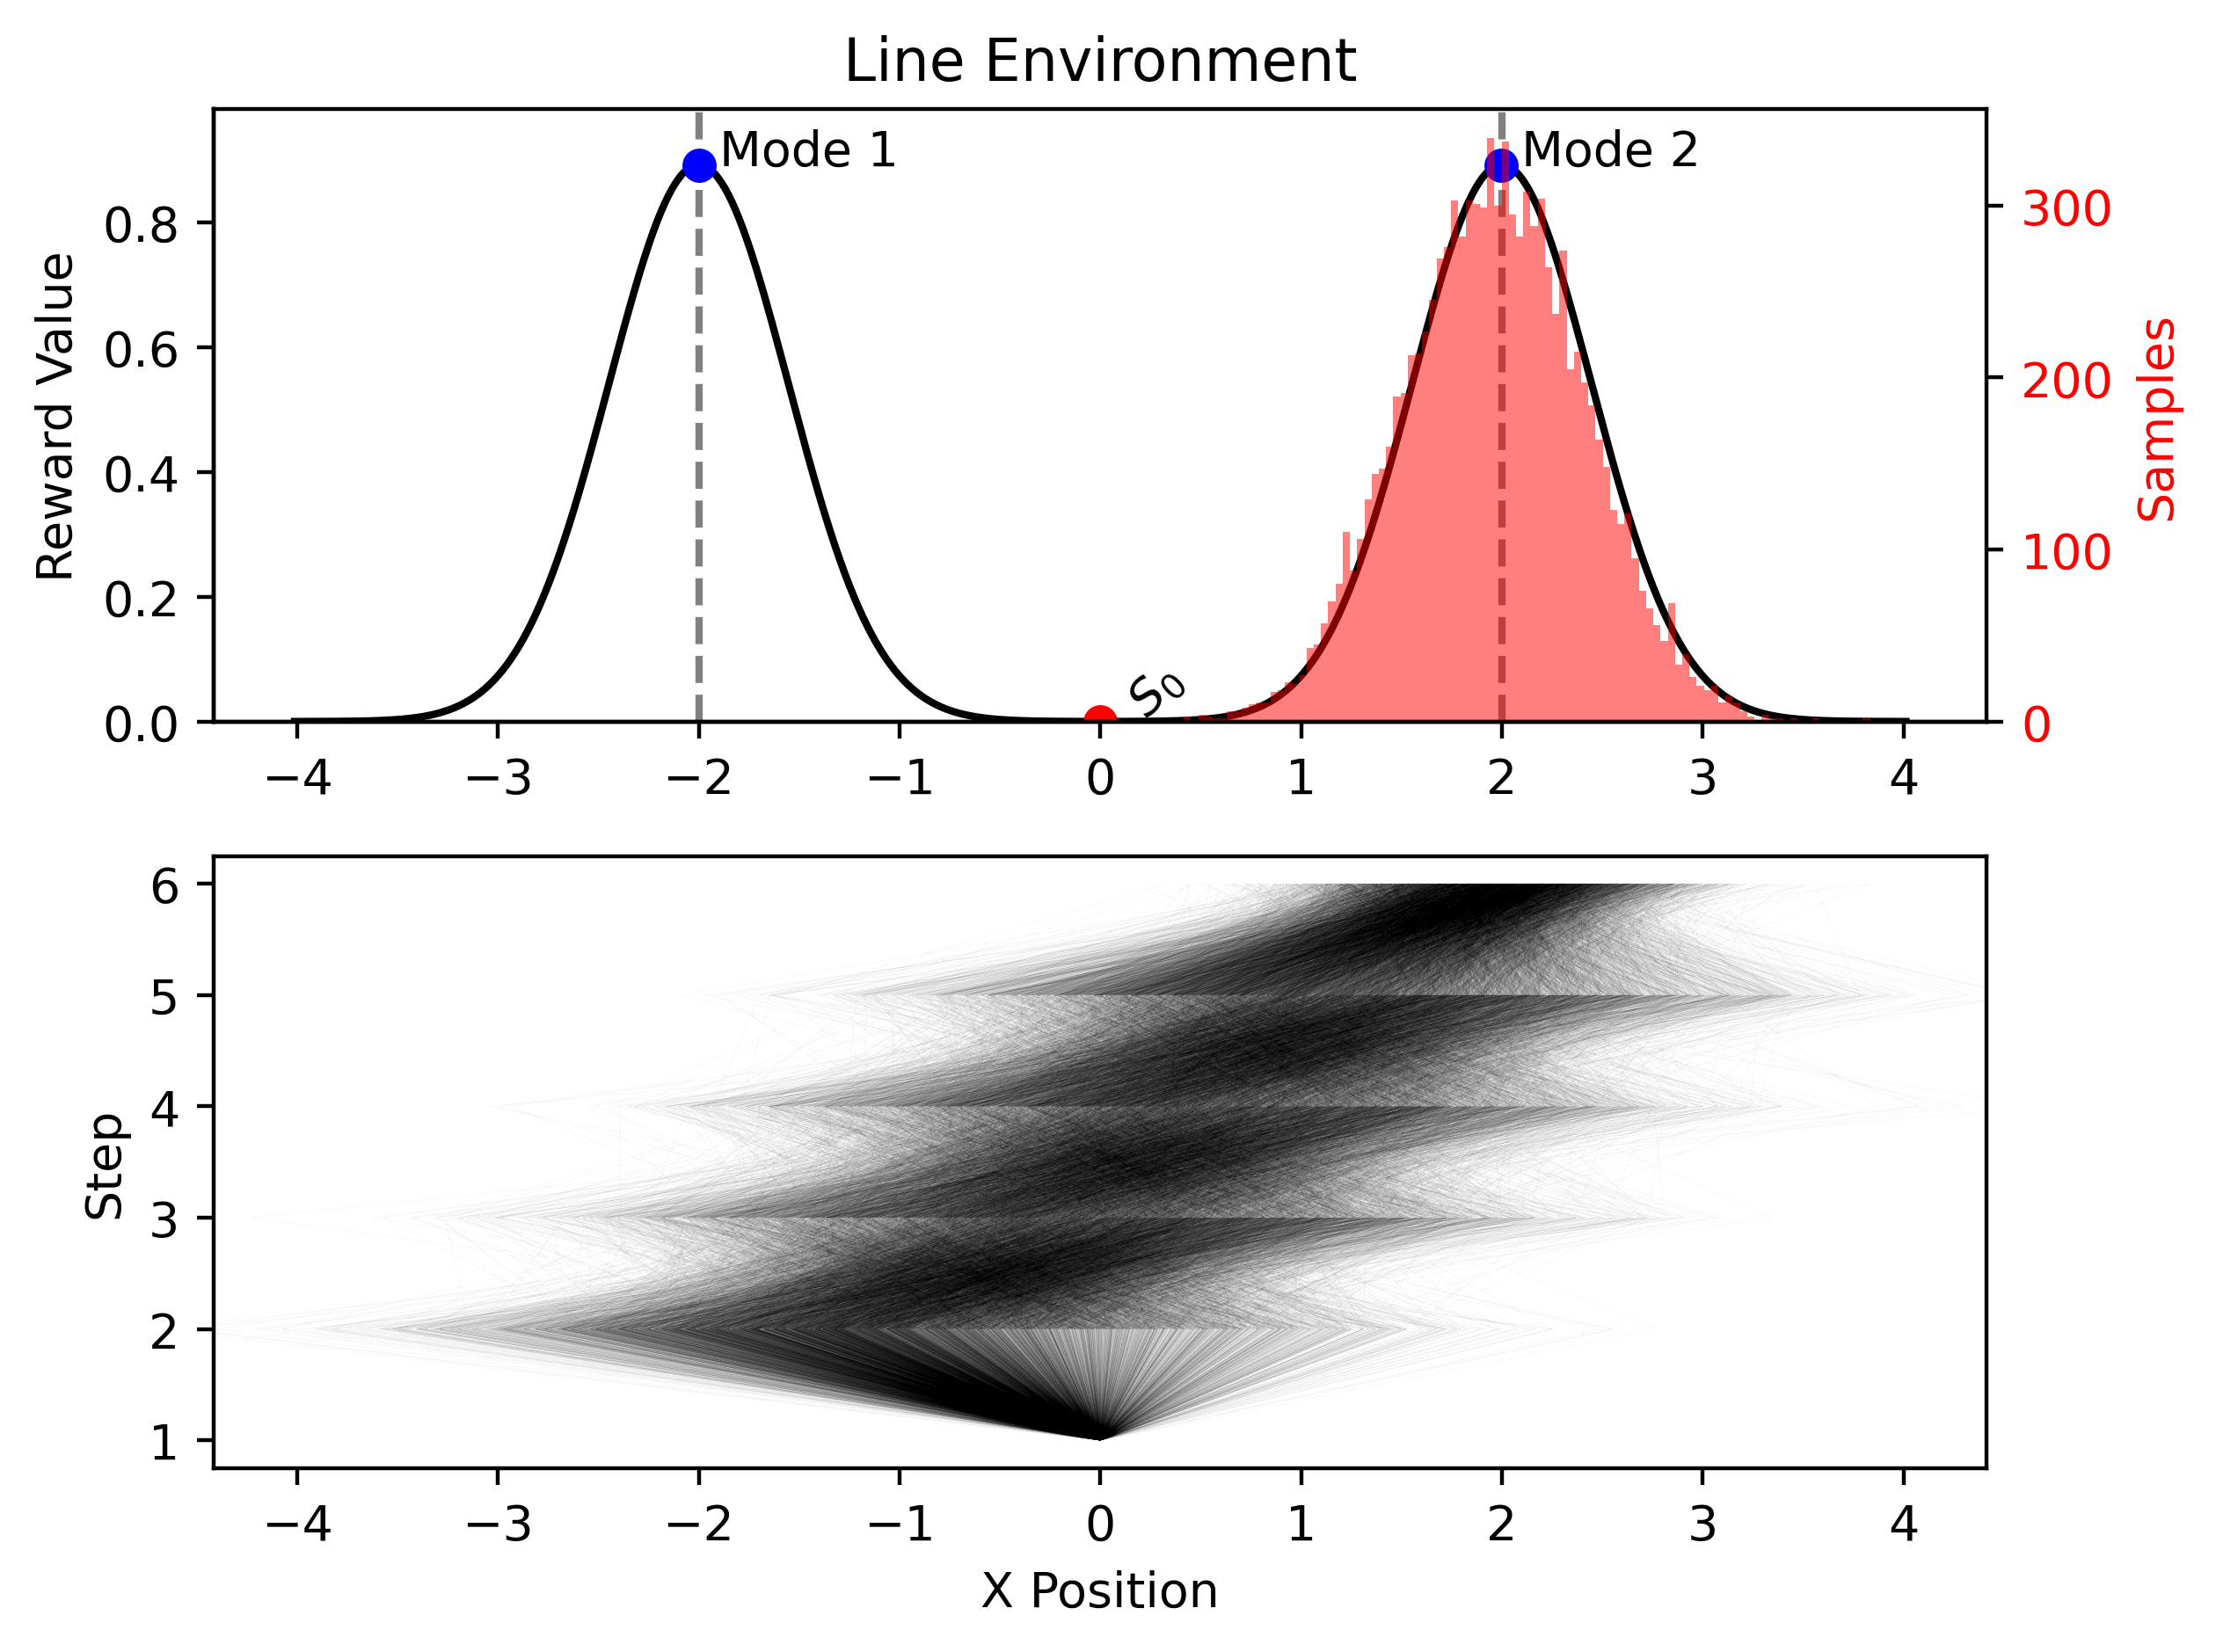

In [13]:
forward_model, backward_model, logZ = train(seed, batch_size, trajectory_length, env, device)
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

### Line With Exploration

+ `trajectory_length`
+ `init_exploration_noise`
+ `min/max_policy_std`
+ `n_iterations`
+ `learning_rate` (for the model and logZ estimate seperately!)
+ `hid_dim`

In [39]:
# Hyperparameters

# Enable better sampling and exploration of this environment, and train for 10k iterations.
# Allow policy to sample from Gaussian distributions with larger sigma values,
# and increase init_exploration_noise value.
init_exploration_noise = 2
trajectory_length = 10
n_iterations = 10_000
min_policy_std = 0.1
max_policy_std = 5.0
batch_size = 256
seed = 444
hid_dim=128
lr_model=0.001
lr_logz=0.05

In [40]:
env = LineEnvironment(
    mus=[-2, 4, 6, 10],
    variances=[0.2, 0.4, 1, 0.2],
    n_sd=4.5,
    init_value=0
)
# render(env)

/tmp/ipykernel_2062/2518502466.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)


Training iter 9900: (loss=1.030, estimated logZ=3.903, LR=0.001, off policy noise=0.0198): 


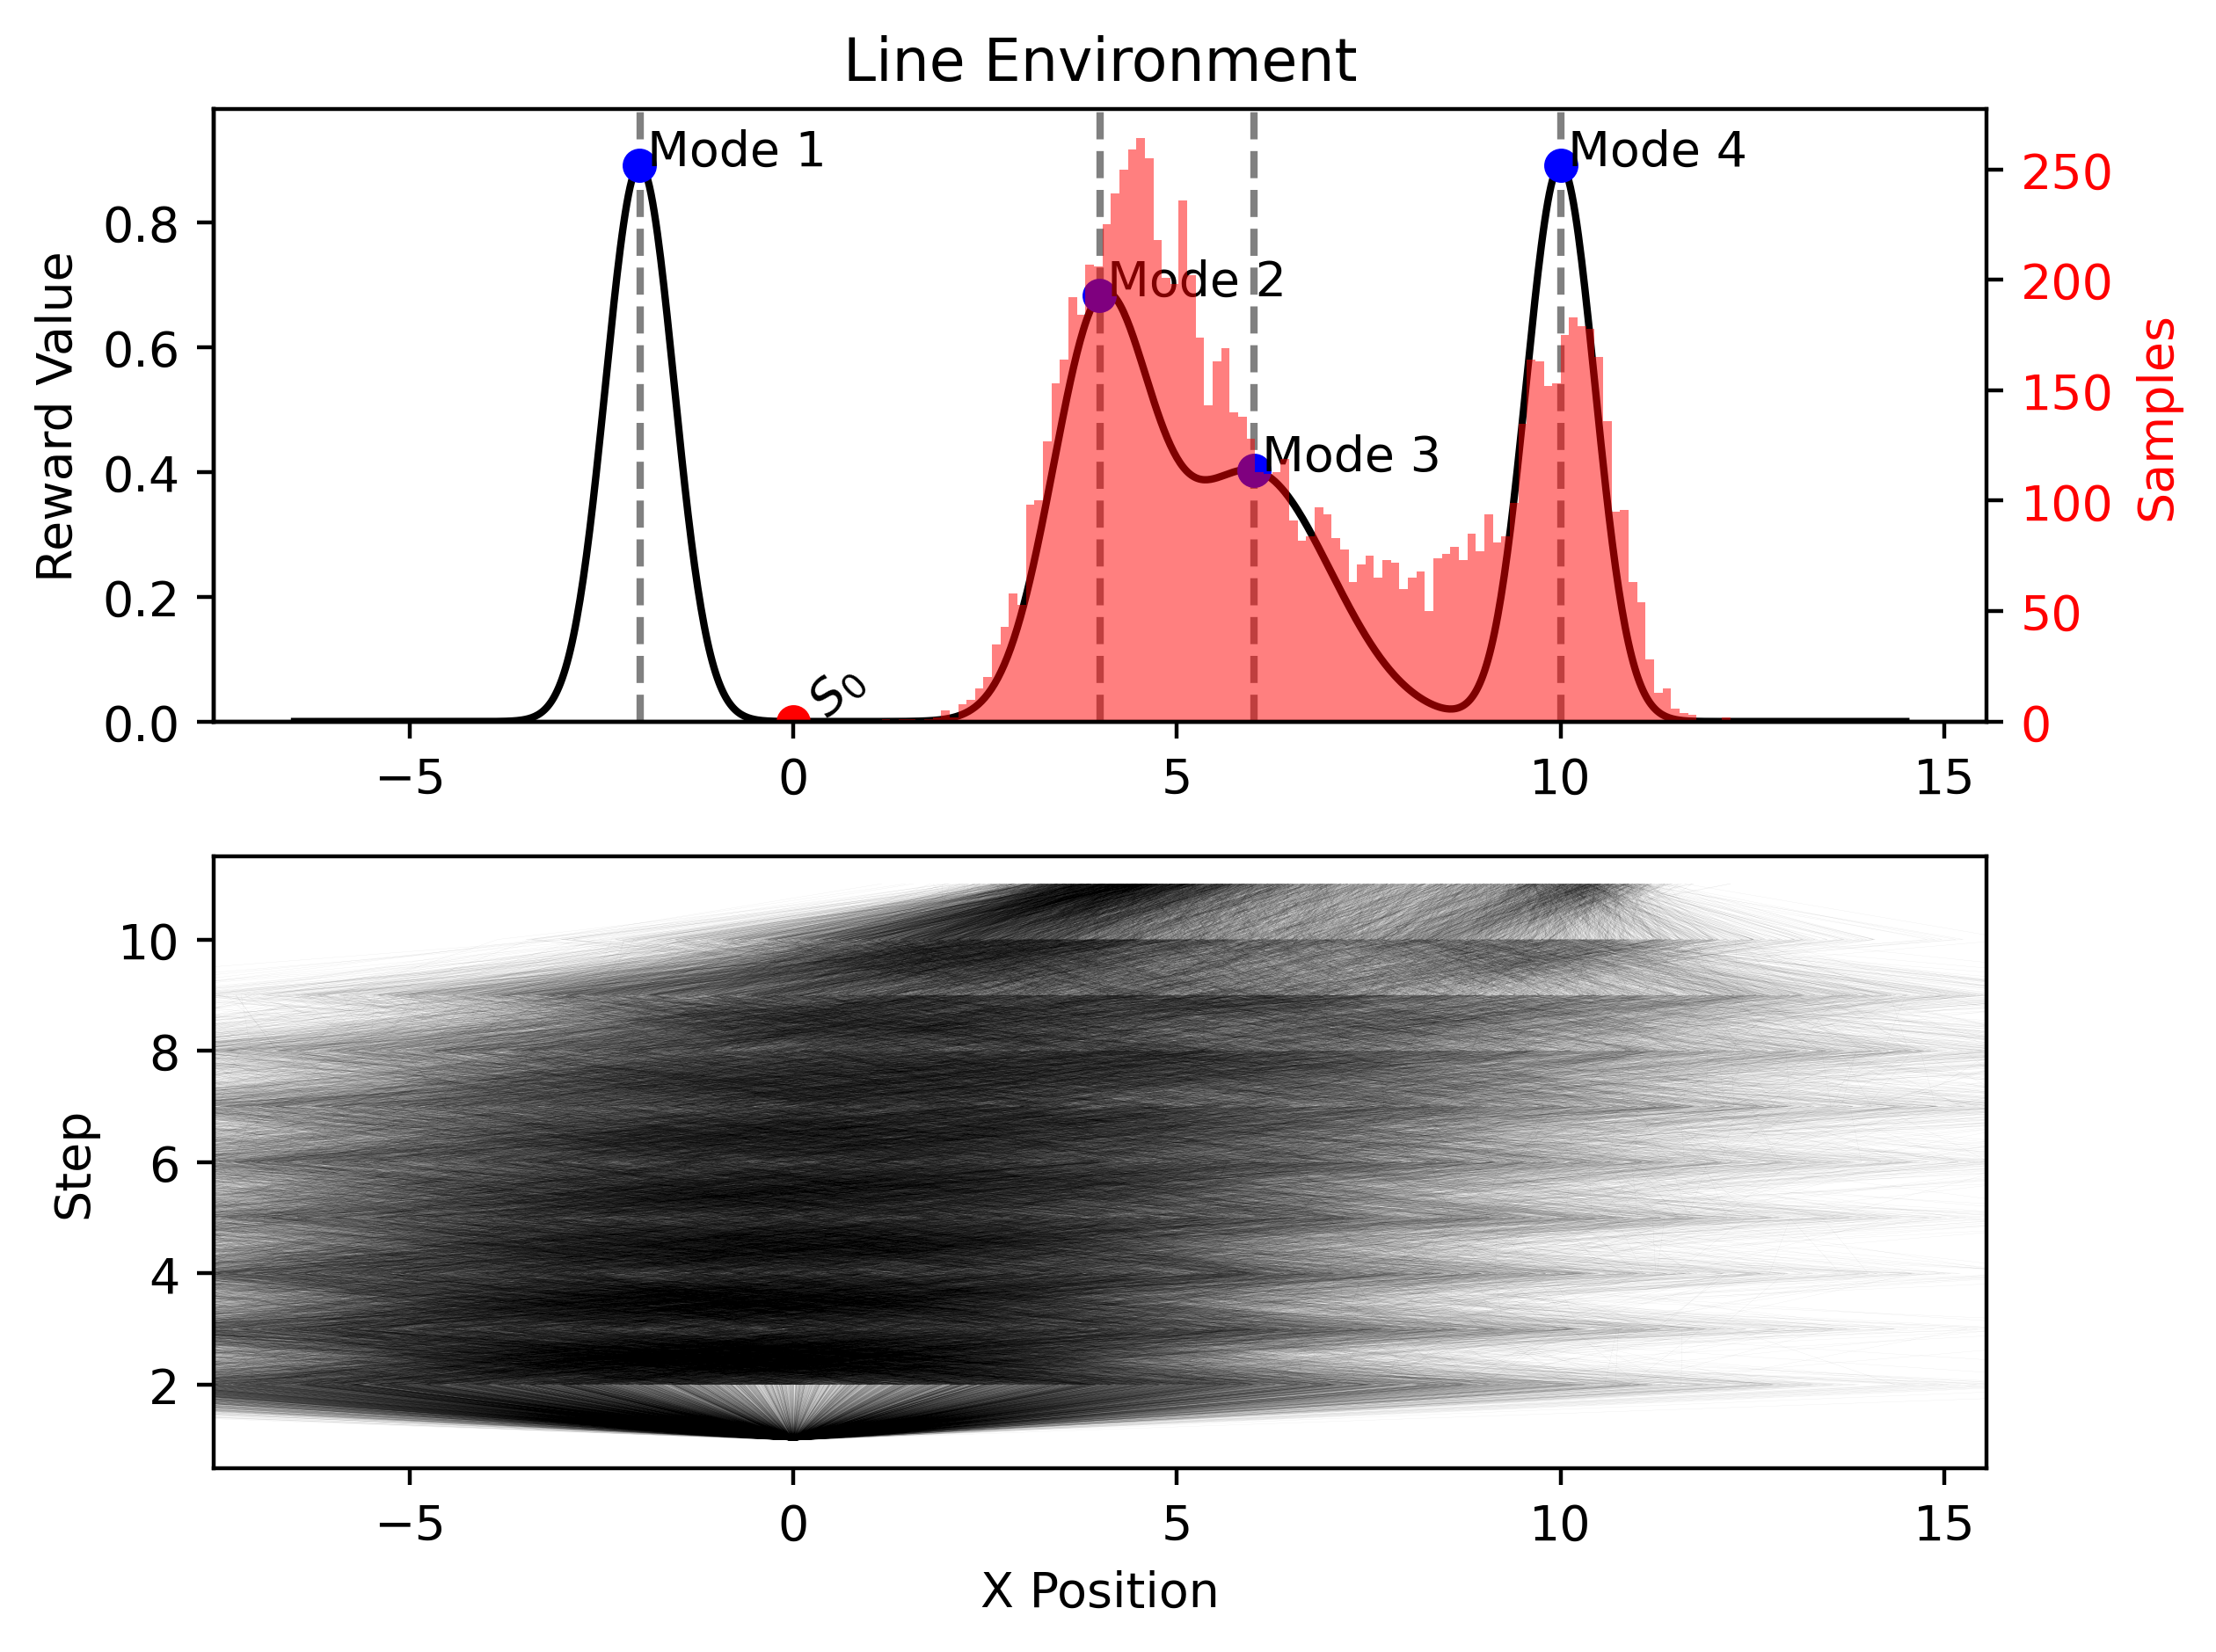

In [41]:
forward_model, backward_model, logZ = train_with_exploration(
    seed,
    batch_size,
    trajectory_length,
    env,
    device,
    init_exploration_noise,
    n_iterations=n_iterations,
    hid_dim=hid_dim,
    lr_model=lr_model,
    lr_logz=lr_logz
)
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)